## Search based on Quantum Singular Value Transformation

Quantum Singular Value Transformation (QSVT) [1] was recently proposed as a scheme that provides a unification of several quantum 
algorithms, creating quite a stir in the community. Simply put, it allows one to carry out polynomial transformation of singular values 
of matrices. 

In this notebook we discuss QSVT in the context of a search problem. For the search problem we are given one or more marked items that we
have to search for. If the marked state is $\vert M \rangle$ and our initial state is $\lvert \psi \rangle$ which has some initial overlap
with the $\vert M \rangle$ i.e. $|\langle M \rvert \psi \rangle| = a$, then the goal of the search algorithm is to make $a \to 1.$ If $a$
is the singular value of a relevant matrix, then the goal of the QSVT will be to implement a function $f(x)$ such it transforms $a$ to 1.
One such example of such a function in the form of sign function is shown below.

### Quantum Signal Processing

QSVT borrows results from Quantum Signal Processing which prescribes how to encode polynomials using X and Z rotations
on a Bloch sphere. One such building block is the operator
$$
    W(x) = \begin{pmatrix}
    x & i\sqrt{1-x^2} \\
    i\sqrt{1-x^2} & -x
    \end{pmatrix}. \tag{1}
$$ 


$W(x)$ is then sandwiched between phase rotations to create another operator 
$$
W_{\Phi}(x):=e^{i \phi_{0} \sigma_{z}} W(x) e^{i \phi_{1} \sigma_{z}} W(x) \cdots W(x) e^{i \phi_{k} \sigma_{z}}.
$$

$W_{\Phi}(x)$ can be used to encode a polynomial into a $2 \times 2$ matrix. 
Formally, it can be proven that there exists a set of phase angles $\phi \in \mathbb{R}^{k+1}$ such that 
$$
    W_{\Phi}(x)=\left(\begin{array}{cc}
    P(x) & i Q(x) \sqrt{1-x^{2}} \\
    i Q^{*}(x) \sqrt{1-x^{2}} & P^{*}(x)
    \end{array}\right) \tag{2} 
$$

where $P$ and $Q$ are polynomials with complex coefficients that satisfy
1. $\operatorname{deg}(P) \leq k$ and $\operatorname{deg}(Q) \leq k-1$,
2. $P$ has parity$^{a)}$ $k \bmod 2$ and $Q$ has parity $(k-1) \bmod 2$, and  
3. $\forall x \in[-1,1],|P(x)|^{2}+\left(1-x^{2}\right)|Q(x)|^{2}=1$ 

Note that, we can rewrite $W(x)$ as X-rotations i.e. 

$$
W(x)=i e^{-i \sigma_{z} \pi / 4} R(x) e^{i \sigma_{z} \pi / 4} \tag{3}
$$

where 

$$
R(x):=\left(\begin{array}{cc}
    x & \sqrt{1-x^{2}} \\
    \sqrt{1-x^{2}} & -x
    \end{array}\right) \tag{4}
$$

As a result, we can write $W_{\Phi}(x)$ (see Eq. 2) in terms of X and Z rotations

$$
\begin{aligned}
    W_{\Phi}(x) &=e^{i \phi_{0} \sigma_{z}} \prod_{j=1}^{k} W(x) e^{i \phi_{j} \sigma_{z}} \\
    &=i^{k} e^{i \phi_{0} \sigma_{z}} \prod_{j=1}^{k} e^{-i \sigma_{z} \pi / 4} R(x) e^{i \sigma_{z}\left(\phi_{j}+\pi / 4\right)}
\end{aligned} \tag{5}
$$

a) Even function has parity 0 and odd function has parity 1.

Note, using the scheme above, we can only get polynomial functions. In order to encode an arbitrary function transform, 
we need to find a polynomial that approximates such a function. The theorem below comes to our rescue.

#### Weirstrass Approximation Theorem:
If $f$ is a continuous real-valued function defined on the real interval $[a, b]$. 
There exists a polynomial $P$ such that for all $x \in [a,b]$, we have
$$
\begin{equation}
    \lvert f(x) - P(x) \rvert \le \epsilon
\end{equation} \tag{6}
$$

This theorem makes sure that we can always find a polynomial approximation of a given function as long as the function is well-behaved. Let's see this
in action in the code below. Here we have the same $W(x)$ and $e^{i\phi Z}$ as discussed above. The sequence of $\phi_i$ is taken from the paper [1]
and when encoded into the Z-rotations gives us the plot for the sign function. This sign function we will use for the QSVT-based search below.

/opt/anaconda3/envs/qiskit/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


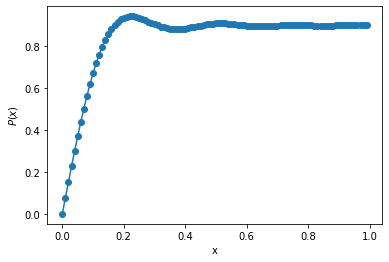

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


phi = [0.01558127, -0.01805798, 0.05705643, -0.01661832,
0.16163773, 0.09379074, -2.62342885, 0.49168481, 
0.92403822, -0.09696846, -0.09696846, 0.92403822,
0.49168481, -2.62342885, 0.09379074, 0.16163773, 
-0.01661832, 0.05705643, -0.01805798, 1.5863776]


def W(x): 

    return np.matrix([[x, 1j * np.sqrt(1 - x**2)],
                   [1j * np.sqrt(1 - x**2), x]])

def rZ(theta):
    
    return np.matrix([[np.exp(-1j * theta), 0],
                   [0, np.exp(1j * theta)]])

def end_m(x):
    
    ans = rZ(phi[0]) 
    for i in range(1, len(phi)):
        ans *= W(x) * rZ(phi[i])

    return ans

px = []
for i in np.arange(0,1,0.01):
    px.append(end_m(i)[0,0])
    
plt.plot(np.arange(0, 1, 0.01), px, '-o')
plt.xlabel('x')
plt.ylabel('$P(x)$')
plt.show()

### Qubitization

What we have discovered so far only applies to single qubit rotations but as we mentioned we want to implement polynomial transformations
to the sigular values of matrices. Let's discuss how we can lift results from the previous section for matrices that are larger than 
size $2 \times 2$. 

For now, let's assume, the given matrix $A$ has its singular value decomposition as

$$
A = \sum_{k} \sigma_k \lvert w_k \rangle \langle v_k \rvert \tag{7}
$$

where $\sigma_k$ and $\{\lvert w_k \rangle, \lvert v_k \rangle\}$ denote singular value and singular vectors of $A$.

QSVT uses an abstraction called "qubitization" where after block-encoding $A$ into a bigger unitary of the form$^{a)}$

$$
    U_A = \begin{array}{c} \Pi \\ \begin{array}{c} \tilde{\Pi} \\\quad \end{array} 
    \begin{pmatrix} A & . \\ . & .\end{pmatrix} \end{array} \tag{8}
$$

one can lift the results from QSP and create a version of $W(x)$ (see Eq. 1) and carry out rotations in this abstracted 
2D subspace spanned by the eigenspace of $A$. Here, the location of $A$ determined by projectors $\Pi$ and $\tilde\Pi$ defined as
$\tilde{\Pi} = |w_k\rangle \langle w_k|$ and $\Pi = |v_k\rangle \langle v_k|$. Hence,

$$A = \tilde{\Pi} U_A \Pi \tag{9}$$

The phase rotations in the QSP sequence is replaced by another unitary

$$
\Pi_{\phi} = e^{\phi (2\Pi - 1)} \tag{10}
$$

where $\Pi$ is a projector on the singular vectors. It may sound abstract for now, but bear with us! We will consider 
the example search problem to make these definitions more concrete. For now, let's state the thorem formally. 

#### Theorem

Given a block encoding of a matrix $A = \sum_k \sigma_k |w_k \rangle \langle v_k|$ in a unitary matrix $U$,
$$
    U_A = \begin{array}{c} \Pi \\ \begin{array}{c} \tilde{\Pi} \\\quad \end{array} 
    \begin{pmatrix} A & . \\ . & .\end{pmatrix} \end{array} \tag{11}
$$

with the location of $A$ determined by projectors $\Pi$ and $\tilde\Pi$, and given the ability to realize projector controlled phase shift 
operations $\Pi_\phi$ and $\tilde{\Pi}_\phi$, then, for odd $d$,

$$  
    \begin{aligned}
    U_{\vec\phi} &= \tilde{\Pi}_{\phi_{1}}  U_{A} \left[ \prod_{k=1}^{(d-1)/2} \Pi_{\phi_{2k}} U_{A}^\dagger \tilde{\Pi}_{\phi_{2k+1}}  
                                                    U_A  \right] \\ 
    &=  \begin{array}{c} \Pi \\ \begin{array}{c} \tilde{\Pi} \\ \quad \end{array} 
        \begin{pmatrix} {\rm Poly}^{({\rm SV})}(A) & . \\ . & .\end{pmatrix}\end{array}
    \end{aligned} \tag{12}
$$
where $ {\rm Poly}^{({\rm SV})}(A)$ is defined for an odd polynomial as
$$
 {\rm Poly}^{({\rm SV})}(A) := \sum_{k} {\rm Poly}(\sigma_k) |w_k \rangle \langle v_k|, \tag{13}
$$
which applies a polynomial transform to the singular values of $A$.  The polynomial is of degree at most $d$ and obeys the conditions of $P$ from 
Theorem in Eq. 1.
            
Similarly, for $d$ even,
$$
\begin{aligned}
      U_{\vec\phi} &= \left[ \prod_{k=1}^{d/2} \Pi_{\phi_{2k-1}} U_{A}^\dagger \tilde{\Pi}_{\phi_{2k}}  U_A  \right] \\ 
    &=  \begin{array}{c} \Pi \\ \begin{array}{c} \tilde{\Pi} \\ \quad \end{array} 
        \begin{pmatrix} {\rm Poly}^{({\rm SV})}(A) & . \\ . & .\end{pmatrix}\end{array}
\end{aligned} \tag{14}
$$

where $ {\rm Poly}^{({\rm SV})}(A)$ is defined for an even polynomial as
    $$
        {\rm Poly}^{({\rm SV})}(A) := \sum_{k} {\rm Poly}(\sigma_k) |v_k \rangle \langle v_k|. \tag{15}
    $$
which is also a polynomial transform of the singular values of $A$, but with the modification that the input and output spaces are both the 
right singular vector space, spanned by $\{ |v_k \rangle \}$. Analogously, the polynomial is of degree at most $d$ and obeys the conditions of 
$P$ from Theorem in Eq. 1.

a) Such unitaries that exactly block-encode $A$ are not always present, one then should work with an unitary that approximately 
block-encodes $A$ [1]. 

##### Implementing $\Pi_{\phi}$

As discussed above (see Eq. 10), we need to implement $\Pi_{\phi} = e^{i \phi (2\Pi-1)}$ as a circuit. How we would do that?
One can write,
$$
\begin{split}
     e^{i\theta(2\Pi-1)} &= e^{i\theta2\Pi}e^{-i\theta} \\
     &= \big(I + (e^{2i\theta} -1)\Pi\big)e^{-i\theta} \\
     &= \big((I-\Pi) + e^{2i\theta}\Pi\big)e^{-i\theta} \\
     &= \big(e^{-i\theta}(I-\Pi) + e^{i\theta}\Pi\big) 
\end{split}
$$

Hence, to implement $\Pi_{\phi}$, we need to implement projector controlled Z-rotation. Say, if the projector $\Pi = |11\rangle \langle 11|$, then the
circuit below can implement $e^{i \phi (2\Pi-1)}$ upto a global phase.

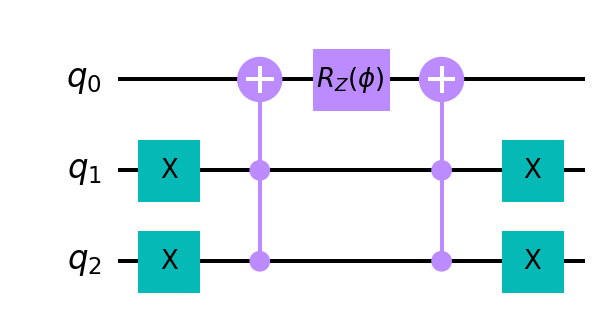

In [12]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

def named_circ(name, nqubit, control=True):
    qc1 = QuantumCircuit(nqubit, name=name)
    if control:
        named_circ = qc1.to_gate().control(1)
    else:
        named_circ = qc1.to_gate()
    
    return named_circ


qc3 = QuantumCircuit(3)

qc3.x(1)
qc3.x(2)
qc3.mcx([1,2], target_qubit=0)
qc3.append(named_circ(r'$R_Z(2\phi)$', nqubit=1, control=False), [0])
qc3.mcx([1,2], target_qubit=0)
qc3.x(1)
qc3.x(2)
 
qc3.draw('mpl', scale=2.0)

#### Example: Search problem

As discussed above, we state a more general version of the search problem in the form of amplitude amplification. In this case we start with a 
state $|\psi_0\rangle$ with a non-zero overlap $a$ with the marked state $|M\rangle$ i.e. $a = |\langle M \rvert \psi \rangle|$. For example, 
during Grover search which is a specific case of amplitude amplification, we start with an equal superposition of all the basis states whereas 
the target state (marked state) is one of the basis states. Hence, in this case $a = \frac{1}{\sqrt{N}}$. 

Next, step is to figure out the matrix $A$. One thing we know about $A$ is that it should have $a$ as its singular value and 
$\{|\psi_0\rangle, |M\rangle\}$ as singular vectors.

If we write $$A = \Pi_{M} U_A \Pi_{\psi_0} = a |M\rangle \langle\psi_0|\tag{14},$$ where $\Pi_{\psi_0} = |\psi_0\rangle \langle \psi_0|$, 
$\Pi_{M} = |M\rangle \langle M|$, and $U_A = \begin{pmatrix} I & 0 \\ 0 & I\end{pmatrix}$, it is clear that $a$ is a singular value of  
$A$ with singular vectors $\{|\psi_0\rangle, |M\rangle\}$ and $U_A$ (indeed a trivial one) can be seen as the block-encoding that block encodes $A$.

Once we have the block-encoding, the projectors, we need to figure out the sequence of phase angles $\phi$ in Eq. 14.

$$
U_{\vec\phi} = \tilde{\Pi}_{\phi_{1}}  U_{A} \left[ \prod_{k=1}^{(d-1)/2} \Pi_{\phi_{2k}} U_{A}^\dagger \tilde{\Pi}_{\phi_{2k+1}}  
                                                    U_A  \right]
$$
We use the phase angles provided in the paper [1] for the sign function, as was shown in the figure above. 
Note, as the length of the $\phi$ sequence given in the paper is even, it means that the degree of the polynomial it implements is odd. 
That's why we use Eq. 12 instead of Eq. 14. 

$\tilde{\Pi}_{\phi} = e^{i\phi (2|\psi_0\rangle \langle \psi_0| - 1)}$ and 
$\Pi_{\phi} = e^{i\phi (2|M\rangle \langle M| - 1)}$. 

Here, for the toy example, we choose $|\psi_0\rangle = R_Y(\theta) \otimes R_Y(\theta)|00\rangle$ and $|M\rangle = |11\rangle$.

In [5]:
from qiskit import IBMQ, BasicAer ,Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
import math as math
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Union, List
from copy import deepcopy
from qiskit.circuit import ParameterVector, Parameter
from collections import defaultdict
from scipy.optimize import minimize
from qiskit.quantum_info.states import partial_trace
from qiskit import QuantumCircuit, QuantumRegister
from qiskit import IBMQ, BasicAer, Aer

#### Using phase angles from the paper

In [164]:
phi = [0.01558127, -0.01805798, 0.05705643, -0.01661832,
0.16163773, 0.09379074, -2.62342885, 0.49168481, 
0.92403822, -0.09696846, -0.09696846, 0.92403822,
0.49168481, -2.62342885, 0.09379074, 0.16163773, 
-0.01661832, 0.05705643, -0.01805798, 1.5863776]

#for i in range(1, len(phi)-1):
#    phi[i] = (phi[i] + np.pi/2.0)
    
#phi[0] = np.pi/4
#phi[-1] = phi[-1] + np.pi/4

#phi[0] = phi[0] - np.pi/4
#phi[-1] = phi[-1] + np.pi/4

print(np.array(phi))

[ 0.01558127 -0.01805798  0.05705643 -0.01661832  0.16163773  0.09379074
 -2.62342885  0.49168481  0.92403822 -0.09696846 -0.09696846  0.92403822
  0.49168481 -2.62342885  0.09379074  0.16163773 -0.01661832  0.05705643
 -0.01805798  1.5863776 ]


In [184]:
def run_qsvt_search(theta):
    
    qc = QuantumCircuit(3)
    d = len(phi) 
    
    qc.ry(theta, 1)
    qc.ry(theta, 2)
    
    for k in range(d//2, 0, -1):
        
        #apply \tilde{Pi}_{phi}
        qc.ry(-theta, 1)
        qc.ry(-theta, 2)
        qc.mcx([1,2], target_qubit=0)
        qc.rz(2 * phi[2*k-1], 0)
        qc.mcx([1,2], target_qubit=0)
        qc.ry(theta, 1)
        qc.ry(theta, 2)
         
        #apply Pi_{\phi}
        qc.x(1)
        qc.x(2)
        qc.mcx([1,2], target_qubit=0)
        qc.rz(2 * phi[2*k-2], 0)
        qc.mcx([1,2], target_qubit=0)
        qc.x(1)
        qc.x(2)
        
        qc.barrier()
        
        
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, backend = simulator).result()
    answer_X = result.get_statevector(qc)
    
    return qc, result, answer_X
    
    
def prepare_initial_state(theta):
    qc = QuantumCircuit(3)

    qc.ry(theta, 1)
    qc.ry(theta, 2)
    
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, backend = simulator).result()
    answer_X = result.get_statevector(qc)
    
    return qc, result, answer_X

def prepare_target_state():
    
    qc = QuantumCircuit(3)

    qc.x(1)
    qc.x(2)
    
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, backend = simulator).result()
    answer_X = result.get_statevector(qc)
    
    return qc, result, answer_X

##### Initial state

In [38]:
qc, result, X = prepare_initial_state(np.pi/2.0)
result.get_counts()
X

Statevector([ 0.5+0.j, -0. +0.j,  0.5+0.j, -0. +0.j,  0.5+0.j, -0. +0.j,
              0.5+0.j,  0. +0.j],
            dims=(2, 2, 2))


##### Final state 

{'000': 0.003112850352541, '010': 0.213713060257172, '100': 0.213713060257172, '110': 0.569461029133113}


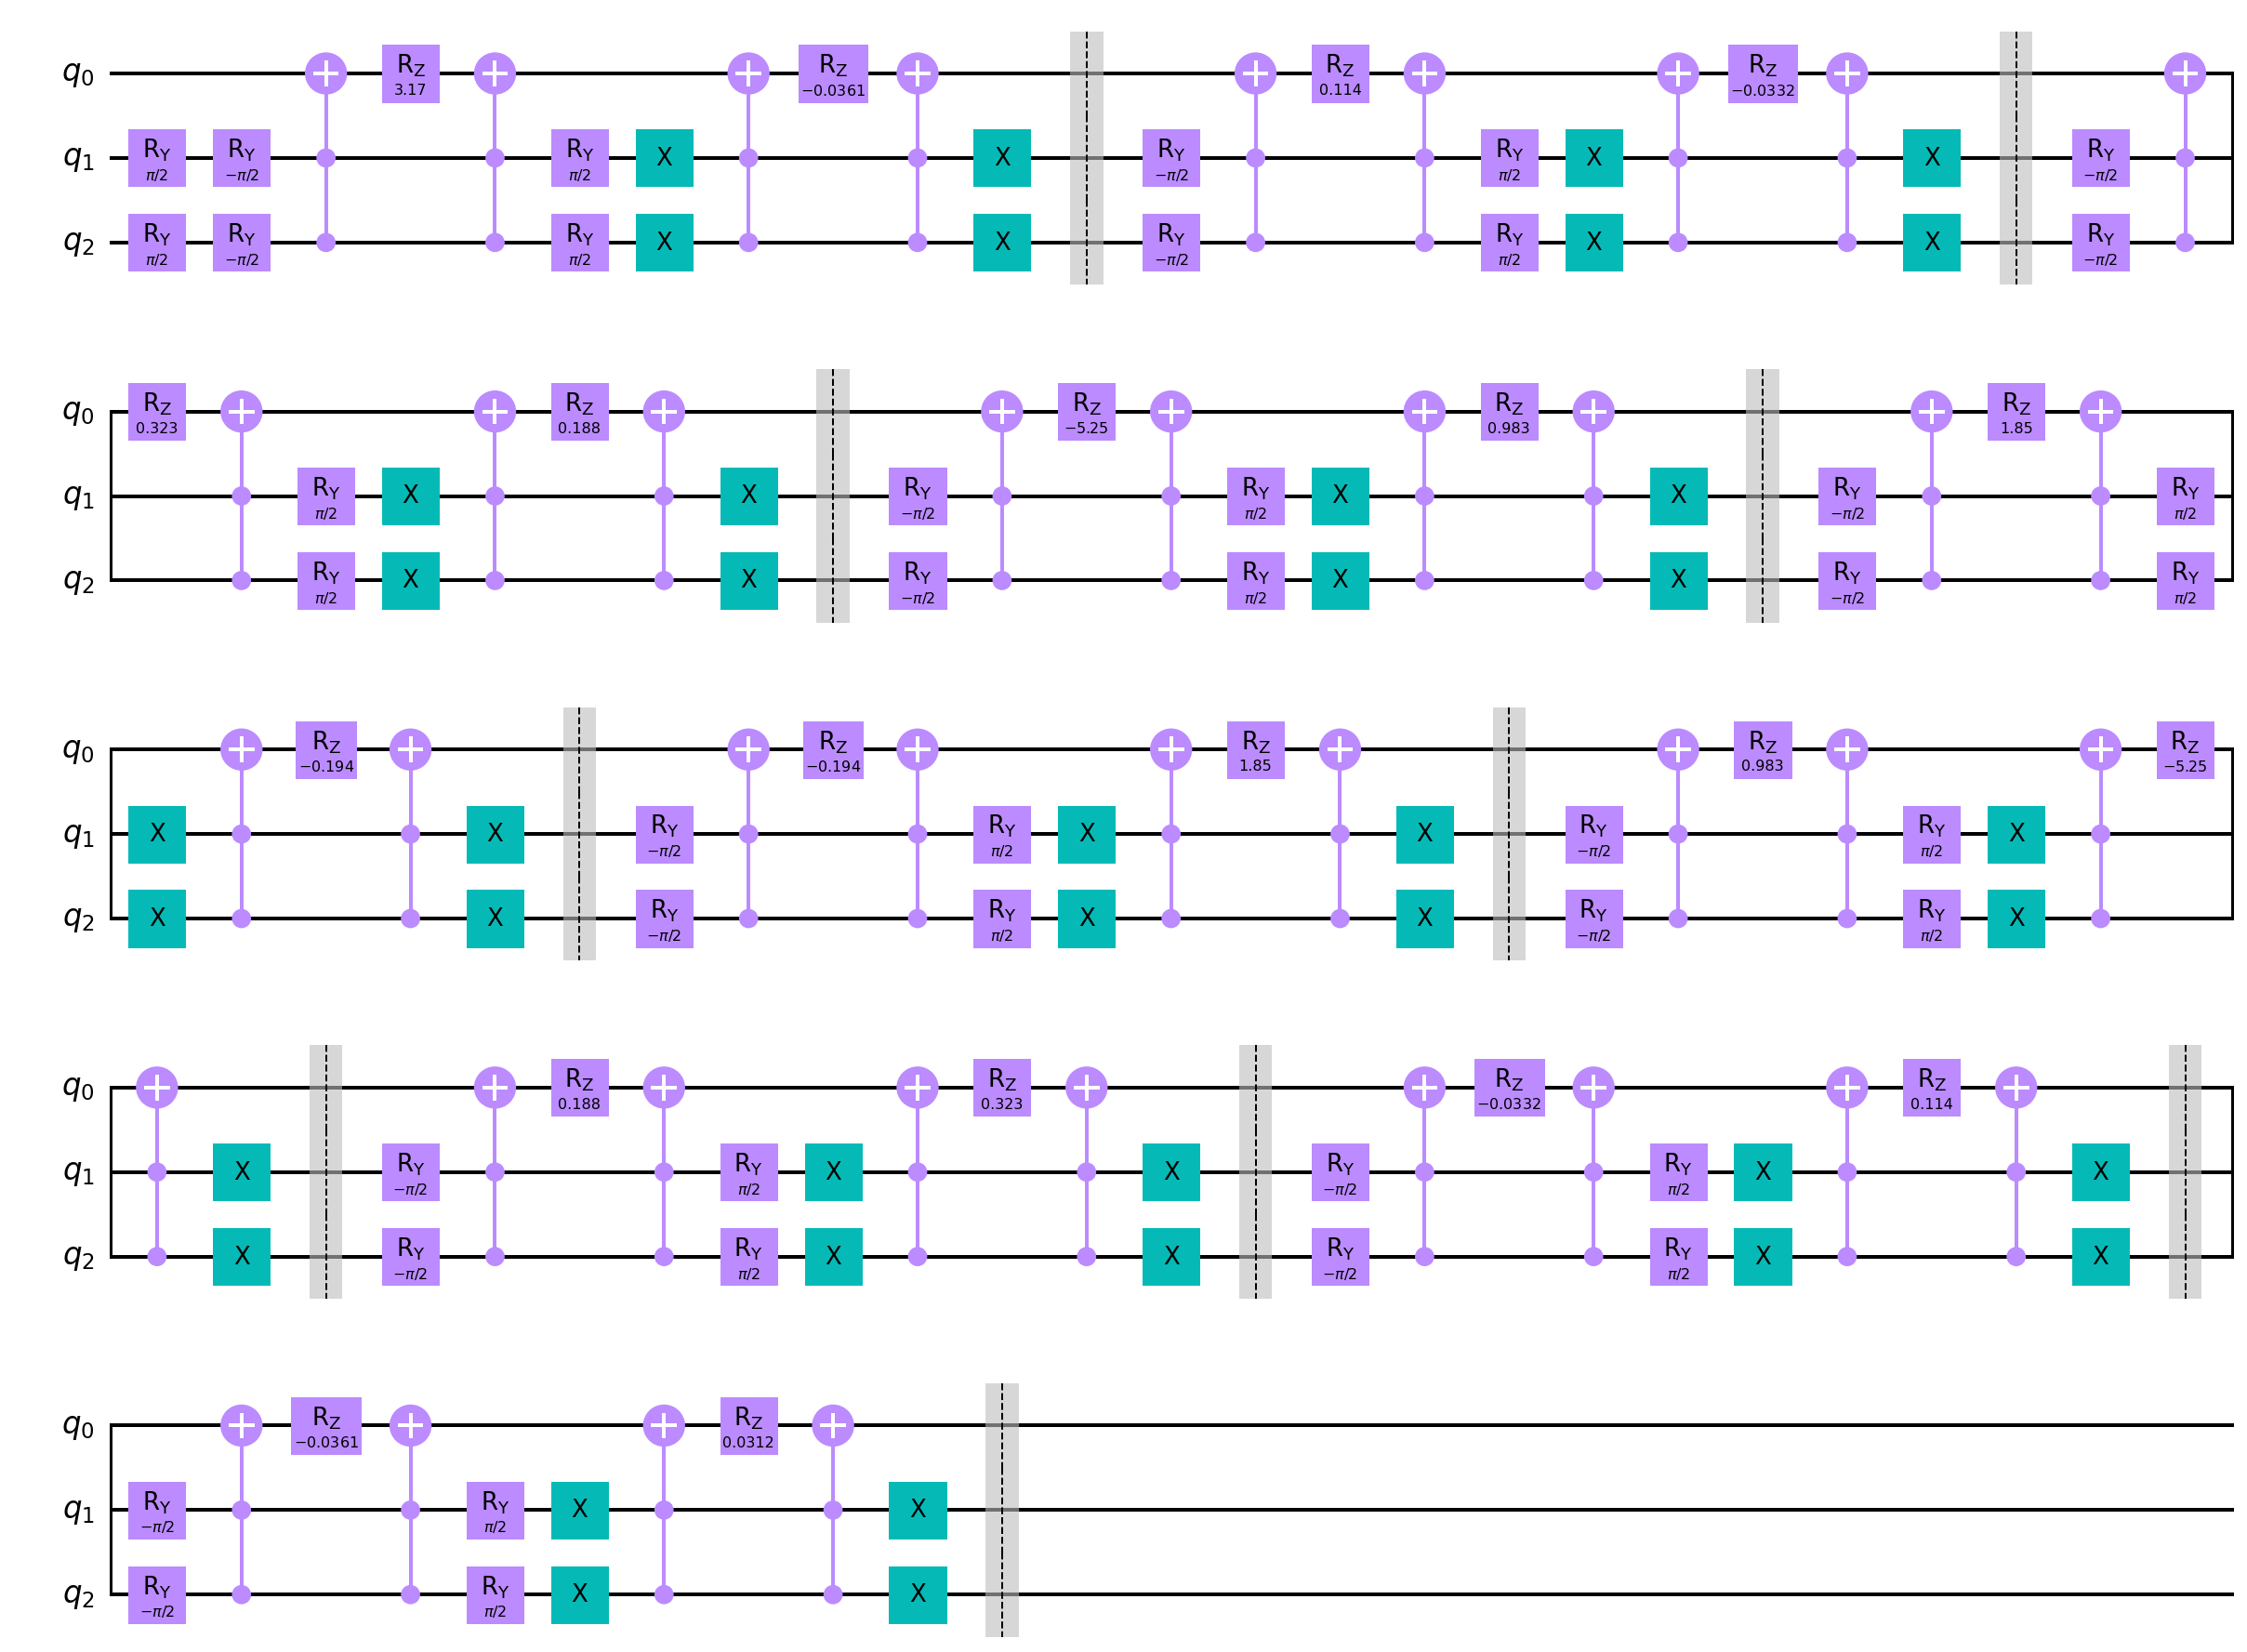

In [185]:
qc, result, X = run_qsvt_search(np.pi/2.0)

print(result.get_counts())
qc.draw('mpl', scale=2.0)

In [ ]:
import collections

xfx = {}

for theta in np.arange(0, 2 * np.pi, np.pi/16):
    fx = 0
    x = 0
    if '110' in run_qsvt_search(theta)[1].get_counts().keys():
        fx += run_qsvt_search(theta)[1].get_counts()['110']
        x += prepare_initial_state(theta)[1].get_counts()['110']
    elif '111' in run_qsvt_search(theta)[1].get_counts().keys():
        fx += run_qsvt_search(theta)[1].get_counts()['111']
        x += prepare_initial_state(theta)[1].get_counts()['111']
    else:
        fx = 0.0
        x = 0.0
                    
    xfx[x] = np.sqrt(fx)

#### Here we plot the final overlap vs the initial overlap 

In [181]:
ordered_xfx = collections.OrderedDict(sorted(xfx.items()))
plt.plot(ordered_xfx.keys(), ordered_xfx.values(), '-o')